In [1]:
%cd mmsegmentation

/home/modan9012/mmsegmentation


In [2]:
# Pytorch 설치 확인
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

import mmcv
print(mmcv.__version__)

# MMSegmentation 설치 확인
import mmseg
print(mmseg.__version__)

1.12.0+cu116 True
2.1.0
1.2.2


In [3]:
import os.path as osp
import numpy as np
from PIL import Image
import mmcv
import mmengine
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os

In [4]:
# dataset root와 이미지, annotation이 위치할 디렉토리 정의
data_root = './datasets/test-small/'
img_dir = 'images'
mask_dir = 'masks'
# 각 클래스에 대한 팔레트(색상)을 정의
classes = ('background', 'kidney')
palette = [[128,0,0],[0,128,0]]

In [5]:
png_file_count = sum(1 for filename in os.listdir(data_root+mask_dir) if filename.endswith('.png'))

print(png_file_count)

12233


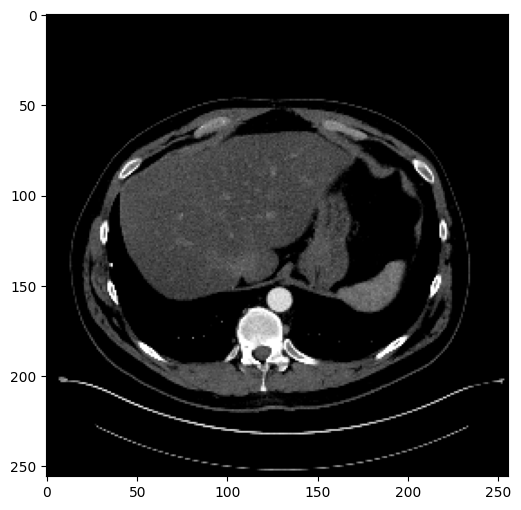

In [11]:
# 다운받은 데이터셋 확인
img = mmcv.imread(f'{data_root}/images/210_000.png')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [6]:
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset


@DATASETS.register_module()
class KiTS21Datasets(BaseSegDataset):
	# 클래스, 팔레트 정보에대한 딕셔너리 METAINFO 생성
  METAINFO = dict(classes = classes, palette = palette)
  def __init__(self, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', **kwargs)

In [7]:
from mmengine import Config
cfg = Config.fromfile('./work_dirs/KiTS21_lr0.001_epoch300_batch16/segmenter_vit-t_mask_8xb1-160k_ade20k-512x512.py')
print(f'Config:\n{cfg.pretty_text}')

Config:
backbone_norm_cfg = dict(eps=1e-06, requires_grad=True, type='LN')
checkpoint = 'https://download.openmmlab.com/mmsegmentation/v0.5/pretrain/segmenter/vit_tiny_p16_384_20220308-cce8c795.pth'
crop_size = (
    256,
    256,
)
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        127.5,
        127.5,
        127.5,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        512,
        512,
    ),
    std=[
        127.5,
        127.5,
        127.5,
    ],
    type='SegDataPreProcessor')
data_root = '/home/modan9012/mmsegmentation/datasets/'
dataset_type = 'KiTS21Datasets'
default_hooks = dict(
    checkpoint=dict(by_epoch=False, interval=5000, type='CheckpointHook'),
    early_stopping=dict(monitor='mIoU', patience=20, type='EarlyStoppingHook'),
    logger=dict(interval=50, log_metric_by_epoch=False, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
 

#### **Test config 설정**

In [8]:
cfg.norm_cfg = dict(type='LN', requires_grad=True)
cfg.crop_size = (256,256)
cfg.model.data_preprocessor.size = (256,256)
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.num_classes = 3
cfg.model.decode_head.out_channels= 3
cfg.model.decode_head.loss_decode=dict(type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)
cfg.model.decode_head.threshold = 0.3

cfg.optim_wrapper.optimizer.lr = 0.001


# 데이터셋 타입과 경로를 수정
cfg.dataset_type = 'KiTS21Datasets'
cfg.data_root = data_root


# test 파이프라인을 설정
cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(256, 256), keep_ratio=True),
    dict(type='PackSegInputs')
]

#test dataloader 설정
cfg.test_dataloader.dataset.type = cfg.dataset_type
cfg.test_dataloader.dataset.data_root = cfg.data_root
cfg.test_dataloader.dataset.data_prefix = dict(img_path=img_dir)
cfg.test_dataloader.dataset.pipeline = cfg.test_pipeline

#test_evaluator 설정
cfg.test_evaluator = dict(
    format_only= True,
    keep_results=True,
    output_dir='./work_dirs/KiTS21_lr0.001_epoch300_batch16/format_results',
    iou_metrics=[
        'mIoU',
    ],
    type='IoUMetric')

# 사전학습된 모델 checkpoint 불러오기
cfg.load_from = './work_dirs/KiTS21_lr0.001_epoch300_batch16/iter_40000.pth'

#로그 디렉토리 설정
cfg.work_dir = './work_dirs/KiTS21_lr0.001_epoch300_batch16'


#결과 재현을 위한 시드 값을 설정
cfg['randomness'] = dict(seed=0)

#최종 설정(config)을 출력
print(f'Config:\n{cfg.pretty_text}')

Config:
backbone_norm_cfg = dict(eps=1e-06, requires_grad=True, type='LN')
checkpoint = 'https://download.openmmlab.com/mmsegmentation/v0.5/pretrain/segmenter/vit_tiny_p16_384_20220308-cce8c795.pth'
crop_size = (
    256,
    256,
)
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        127.5,
        127.5,
        127.5,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        512,
        512,
    ),
    std=[
        127.5,
        127.5,
        127.5,
    ],
    type='SegDataPreProcessor')
data_root = './datasets/test-small/'
dataset_type = 'KiTS21Datasets'
default_hooks = dict(
    checkpoint=dict(by_epoch=False, interval=5000, type='CheckpointHook'),
    early_stopping=dict(monitor='mIoU', patience=20, type='EarlyStoppingHook'),
    logger=dict(interval=50, log_metric_by_epoch=False, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=d

In [9]:
from mmengine.runner import Runner

runner = Runner.from_cfg(cfg)

04/11 23:55:36 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.8.19 | packaged by conda-forge | (default, Mar 20 2024, 12:47:35) [GCC 12.3.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 0
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    GCC: gcc (Debian 10.2.1-6) 10.2.1 20210110
    PyTorch: 1.12.0+cu116
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.6
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-

/home/modan9012/mmsegmentation/mmseg/models/backbones/vit.py:233: UserWarning: DeprecationWarning: pretrained is deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is deprecated, '
/home/modan9012/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


04/11 23:55:39 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
04/11 23:55:39 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
(LOWEST      ) EarlyStoppingHook                  
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_i

/home/modan9012/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:60: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


In [10]:
# 모델 학습 진행
runner.test()

04/11 23:55:40 - mmengine - WARNING - The prefix is not set in metric class IoUMetric.


/opt/conda/envs/openmmlab/lib/python3.8/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/home/modan9012/mmsegmentation/mmseg/datasets/transforms/loading.py:84: UserWarning: `reduce_zero_label` will be deprecated, if you would like to ignore the zero label, please set `reduce_zero_label=True` when dataset initialized
  warnings.warn('`reduce_zero_label` will be deprecated, '
/opt/conda/envs/openmmlab/lib/python3.8/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, whi

Loads checkpoint by local backend from path: ./work_dirs/KiTS21_lr0.001_epoch300_batch16/iter_40000.pth
04/11 23:55:42 - mmengine - INFO - Load checkpoint from ./work_dirs/KiTS21_lr0.001_epoch300_batch16/iter_40000.pth
04/11 23:55:48 - mmengine - INFO - Iter(test) [   50/12233]    eta: 0:26:12  time: 0.0175  data_time: 0.0009  memory: 30  
04/11 23:55:49 - mmengine - INFO - Iter(test) [  100/12233]    eta: 0:14:44  time: 0.0165  data_time: 0.0009  memory: 30  
04/11 23:55:50 - mmengine - INFO - Iter(test) [  150/12233]    eta: 0:10:52  time: 0.0168  data_time: 0.0009  memory: 30  
04/11 23:55:51 - mmengine - INFO - Iter(test) [  200/12233]    eta: 0:08:57  time: 0.0170  data_time: 0.0009  memory: 30  
04/11 23:55:51 - mmengine - INFO - Iter(test) [  250/12233]    eta: 0:07:48  time: 0.0160  data_time: 0.0009  memory: 30  
04/11 23:55:52 - mmengine - INFO - Iter(test) [  300/12233]    eta: 0:07:01  time: 0.0160  data_time: 0.0009  memory: 30  
04/11 23:55:53 - mmengine - INFO - Iter(tes

{}

In [ ]:
!python ./evaluation_mask_9-2.py

In [11]:
cd ..

/home/modan9012


In [2]:
import shutil

# 압축할 폴더 경로
directory = '/home/modan9012/mmsegmentation-swin/'

# 압축 파일의 경로 및 이름 (확장자 제외)
output_filename = '/home/modan9012/mmsegmentation-swin/'

# 폴더를 ZIP 파일로 압축
shutil.make_archive(output_filename, 'zip', directory)

print(f'{output_filename}.zip 파일이 생성되었습니다.')


KeyboardInterrupt: 